In [64]:
from torch.utils.data import Dataset
from PIL import Image
import os

class CustomDataset(Dataset):
    def __init__(self, root, folder_name, batch_size=8, target_size=(256, 256), transform=None, mode="train", max_samples=10):
        self.root = root
        self.folder_name = folder_name + "\\images\\"
        self.batch_size = batch_size
        self.transform = transform
        self.mode = mode
        self.target_size = target_size
        self.images_folder = os.path.join(self.root, self.mode, self.folder_name)

        self.image_files = sorted(os.listdir(self.images_folder))[:max_samples]  # Limit to max_samples
        self.num_samples = min(len(self.image_files), max_samples)
        self.max_samples = min(max_samples, self.num_samples)

    def __len__(self):
        return (self.max_samples + self.batch_size - 1) // self.batch_size

    def __getitem__(self, idx):
        start_idx = idx * self.batch_size
        end_idx = min((idx + 1) * self.batch_size, self.max_samples)

        images_batch = []
        labels_batch = []
        for i in range(start_idx, end_idx):
            img_name = self.image_files[i]
            img_path = os.path.join(self.images_folder, img_name)
            image = Image.open(img_path).convert('RGB')

            # Resize images
            if self.transform:
                image = self.transform(image)

            # Load labels here if available
            # Assuming labels are stored in a separate folder with the same structure
            label_name = img_name  # Modify this based on your dataset structure
            label_path = os.path.join(self.root, self.mode, self.folder_name, label_name)  # Adjust path based on your dataset structure
            label = Image.open(label_path).convert('L')  # Convert to grayscale

            if self.transform:
                label = self.transform(label)

            images_batch.append(image)
            labels_batch.append(label)

        return images_batch, labels_batch  # Return both images and labels as padded sequences

In [66]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# from src.CustomDataset import CustomDataset 

# Define U-Net architecture
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.down_conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.down_conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.up_conv1 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.up_conv2 = nn.Conv2d(64, 3, kernel_size=3, padding=1)

    def forward(self, x):
        # Downward path
        x1 = F.relu(self.down_conv1(x))
        x2 = self.pool(F.relu(self.down_conv2(x1)))

        # Upward path
        x = F.interpolate(x2, scale_factor=2, mode='bilinear', align_corners=True)
        x = F.relu(self.up_conv1(x))
        x = F.relu(self.up_conv2(x))

        return x


# Define transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize images to a fixed size
    transforms.ToTensor(),  # Convert images to PyTorch tensors
])

# Specify the folder you want to access inside the train folder
image_type = 'church'  
batch_size = 8 
train_data = CustomDataset(root=".\\data", folder_name=image_type, batch_size=batch_size, transform=transform, max_samples=8)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

# Initialize model, loss function, and optimizer
model = UNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [92]:
# Training loop
epochs = 5
for epoch in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data

        # Concatenate images along the batch dimension
        inputs = torch.cat(inputs, dim=0)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, torch.cat(labels, dim=0).squeeze(1).long())  # Concatenate labels and ensure they are 1D
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 100 == 99:
            print(f"[Epoch {epoch + 1}, Batch {i + 1}] Loss: {running_loss / 100:.3f}")
            running_loss = 0.0

print("Training Finised..")

Training Finised..


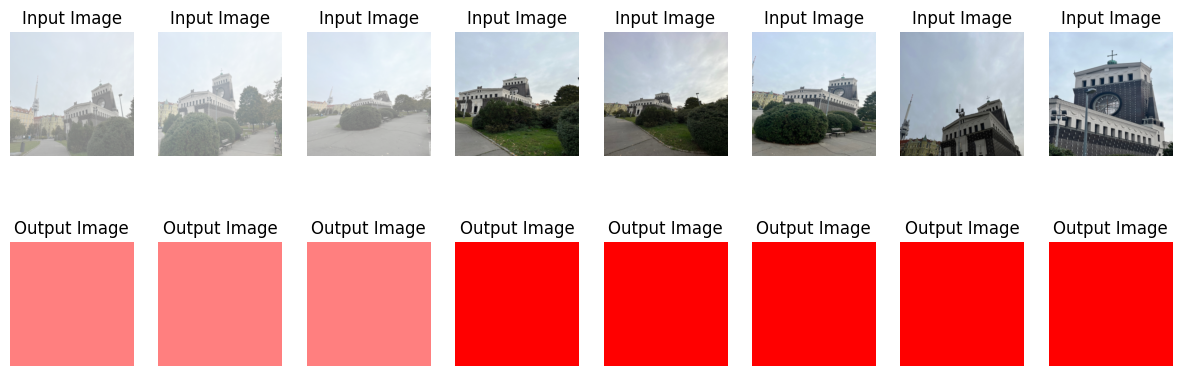

In [98]:
import matplotlib.pyplot as plt
import numpy as np

# Define inverse transformations if applicable
def denormalize(tensor, mean, std):
    """
    Denormalize a tensor image with mean and standard deviation.

    Args:
        tensor (Tensor): Tensor image of size (C, H, W) to be denormalized.
        mean (sequence): Sequence of means for each channel.
        std (sequence): Sequence of standard deviations for each channel.

    Returns:
        Tensor: Denormalized Tensor image.
    """
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

# Plot denormalized images after training finishes
with torch.no_grad():
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data

        # Concatenate images along the batch dimension
        inputs = torch.cat(inputs, dim=0)

        # Transform inputs and outputs back for comparison
        # Apply inverse transformations to inputs and outputs
        inputs_original = denormalize(inputs.clone(), mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Example denormalization
        outputs = model(inputs)
        outputs_original = denormalize(outputs.clone(), mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Example denormalization
        # Further reverse any other transformations applied

        # Plot denormalized images for comparison
        num_images = min(8, inputs_original.size(0))  # Plot up to 8 images
        fig, axes = plt.subplots(2, num_images, figsize=(15, 5))
        for j in range(num_images):
            # Plot original input image
            input_img = inputs_original[j].permute(1, 2, 0).numpy()  # Convert to numpy array and permute dimensions
            input_img = np.clip(input_img, 0, 1)  # Clip pixel values to [0, 1]
            axes[0, j].imshow(input_img)
            axes[0, j].set_title('Input Image')
            axes[0, j].axis('off')

            #for output
            output_img = outputs_original[j].permute(1, 2, 0).numpy()  # Convert to numpy array and permute dimensions
            output_img = np.clip(output_img, 0, 1)  # Clip pixel values to [0, 1]
            axes[1, j].imshow(output_img)
            axes[1, j].set_title('Output Image')
            axes[1, j].axis('off')


        plt.show()  # Show plot for this batch

In [87]:
print("Input Shape: ", inputs[0].shape)
print("Output Shape: ", outputs[0].shape)

Input Shape:  torch.Size([3, 256, 256])
Output Shape:  torch.Size([3, 256, 256])
